# Data analysis: Covid cases over time

Data analysis of daily new covid cases in different countries, using data from:

https://github.com/CSSEGISandData/COVID-19

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pycountry import countries
from datetime import datetime, timedelta

In [2]:
plt.style.use("ggplot")

In [3]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 200

## Import and clean up data

In [4]:
def read_csv(file, response):
    return (
        pd.read_csv(file)
        # Remove unused columns
        .drop(["Lat", "Long"], axis=1)
        # Rename the columns
        .rename(columns={"Country/Region": "country", "Province/State": "province"})
        # Make the date a column
        .melt(id_vars=["province", "country"], var_name="date", value_name=response)
        # Convert the date from string to a real date
        .assign(**{"date": lambda df: pd.to_datetime(df["date"])})
        # Aggregate provinces
        .groupby(["country", "date"])
        .sum()
        # Convert cumulative totals to daily increments
        .groupby(level="country")
        .diff()
    )

In [5]:
cases_df = read_csv("time_series_covid19_confirmed_global.csv", "cases")

In [6]:
cases_df.head(5)

cases
country     date             
Afghanistan 2020-01-22    NaN
            2020-01-23    0.0
            2020-01-24    0.0
            2020-01-25    0.0
            2020-01-26    0.0

In [7]:
deaths_df = read_csv("time_series_covid19_deaths_global.csv", "deaths")

In [8]:
deaths_df.head(5)

deaths
country     date              
Afghanistan 2020-01-22     NaN
            2020-01-23     0.0
            2020-01-24     0.0
            2020-01-25     0.0
            2020-01-26     0.0

Read population data from https://data.worldbank.org/indicator/SP.POP.TOTL?view=chart:

In [9]:
pop_df = (
    pd.read_csv("worldbank_pop.csv")
    .loc[:, ["Country Code", "2020"]]
    .assign(pop_mln=lambda df: df["2020"]/1_000_000)
    .rename(columns={"Country Code": "country_code"})
    .loc[:, ["country_code", "pop_mln"]]
    .set_index("country_code")
    .sort_index()
)

In [10]:
pop_df.head(3)

,pop_mln
country_code,
ABW,0.106766
AFE,677.243299
AFG,38.928341


Map country names from the John-Hopkins University Covid datasets to three letter ISO codes using pycountry:

In [11]:
country_names = cases_df.index.levels[0].values
country_names_to_codes = {}
country_names_unmapped = []
for country_name in country_names:
    try:
        search_results = countries.search_fuzzy(country_name)
        country_names_to_codes[country_name] = search_results[0].alpha_3
    except LookupError:
        country_names_unmapped.append(country_name)
(len(country_names_to_codes), len(country_names_unmapped), len(country_names))

(186, 10, 196)

Country names that could not be mapped:

In [12]:
country_names_unmapped

['Burma',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Diamond Princess',
 'Korea, South',
 'Laos',
 'MS Zaandam',
 'Summer Olympics 2020',
 'Taiwan*',
 'West Bank and Gaza']

In [13]:
country_names_to_codes = pd.Series(country_names_to_codes, name="country_code")
country_names_to_codes.head(5)

Afghanistan    AFG
Albania        ALB
Algeria        DZA
Andorra        AND
Angola         AGO
Name: country_code, dtype: object

Join all the dataframes:

In [15]:
df = (
    cases_df.join(deaths_df)
    .join(country_names_to_codes, on="country", how="inner")
    .join(pop_df, on="country_code", how="inner")
    .drop(columns="country_code")
    .loc[lambda df: df["pop_mln"].notna()]
    .assign(cases_per_mln=lambda df: df["cases"] / df["pop_mln"],
            deaths_per_mln=lambda df: df["deaths"] / df["pop_mln"])
)

In [16]:
df.groupby("country").tail(1).head(30)

,,cases,deaths,pop_mln,cases_per_mln,deaths_per_mln
country,date,,,,,
Afghanistan,2021-12-04,19.0,1.0,38.928341,0.488076,0.025688
Albania,2021-12-04,357.0,1.0,2.837743,125.804204,0.352393
Algeria,2021-12-04,185.0,7.0,43.851043,4.218828,0.159631
Andorra,2021-12-04,0.0,0.0,0.077265,0.000000,0.000000
Angola,2021-12-04,21.0,0.0,32.866268,0.638953,0.000000
Antigua and Barbuda,2021-12-04,1.0,0.0,0.097928,10.211584,0.000000
Argentina,2021-12-04,1690.0,4.0,45.376763,37.243732,0.088151
Armenia,2021-12-04,419.0,25.0,2.963234,141.399565,8.436728
Australia,2021-12-04,1249.0,8.0,25.687041,48.623740,0.311441


Countries where the population could not be joined and are hence not included in the final dataframe:

In [17]:
set(cases_df.index.levels[0].values) - set(df.index.levels[0].values)

{'Burma',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Diamond Princess',
 'Korea, South',
 'Laos',
 'MS Zaandam',
 'Summer Olympics 2020',
 'Taiwan*',
 'West Bank and Gaza'}

## Analyze

In [18]:
date_from = pd.to_datetime("2021-06-01")
date_to   = pd.to_datetime("2021-12-31")

countries = sorted([
    "US",
    "Germany",
    "United Kingdom",
    "Russia",
    "Poland",
    "Ukraine",
    "Czechia"
])

In [19]:
def plot(df, plot_title):
    fig, ax = plt.subplots(figsize=(16,5))
    for col in df.columns:
        ax.plot(df.index, df[col], label=col)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
    ax.set_title(plot_title)

### Moving average of cases and deaths

In [20]:
def moving_average(df, date_from, date_to):
    window_in_days = 7
    return (
        df.loc[(slice(None), slice(date_from - timedelta(days=window_in_days-1), date_to)), :]
        .groupby(level="country")
        .apply(lambda s: s.rolling(window_in_days).mean())
        .loc[(countries, slice(date_from, date_to)), :]
    )

In [21]:
cases_moving_average = moving_average(df.loc[countries], date_from, date_to)
cases_moving_average.groupby(level="country").tail(2)

cases       deaths     pop_mln  \
country        date                                                 
Czechia        2021-12-03   17445.000000   115.285714   10.698896   
               2021-12-04   17063.000000   118.857143   10.698896   
Germany        2021-12-03   56950.714286   309.714286   83.240525   
               2021-12-04   56739.714286   308.000000   83.240525   
Poland         2021-12-03   23198.000000   359.857143   37.950802   
               2021-12-04   23110.428571   377.714286   37.950802   
Russia         2021-12-03   32619.142857  1189.857143  144.104080   
               2021-12-04   32512.714286  1187.285714  144.104080   
US             2021-12-03  116229.142857  1606.000000  329.484123   
               2021-12-04  121437.285714  1651.714286  329.484123   
Ukraine        2021-12-03   11733.285714   521.857143   44.134693   
               2021-12-04   11558.857143   502.142857   44.134693   
United Kingdom 2021-12-03   44633.714286   119.714286   67.215293   
               2021-12-04   44882.285714   119.142857   67.215293   

                           cases_per_mln  deaths_per_mln  
country        date                                       
Czechia        2021-12-03    1630.542067       10.775478  
               2021-12-04    1594.837449       11.109290  
Germany        2021-12-03     684.170532        3.720715  
               2021-12-04     681.635709        3.700121  
Poland         2021-12-03     611.265079        9.482201  
               2021-12-04     608.957581        9.952735  
Russia         2021-12-03     226.358219        8.256929  
               2021-12-04     225.619665        8.239085  
US             2021-12-03     352.760982        4.874286  
               2021-12-04     368.567944        5.013031  
Ukraine        2021-12-03     265.851758       11.824193  
               2021-12-04     261.899571       11.377509  
United Kingdom 2021-12-03     664.041058        1.781057  
               2021-12-04     667.739196        1.772556

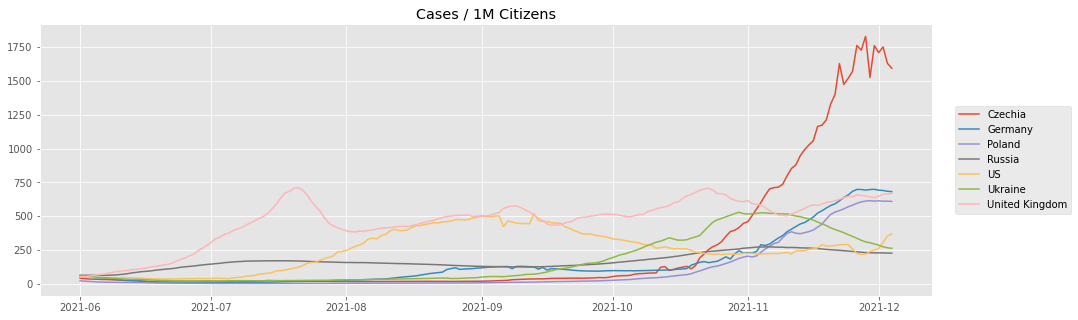

In [22]:
plot(cases_moving_average.loc[:, "cases_per_mln"].unstack(level="country"), "Cases / 1M Citizens")

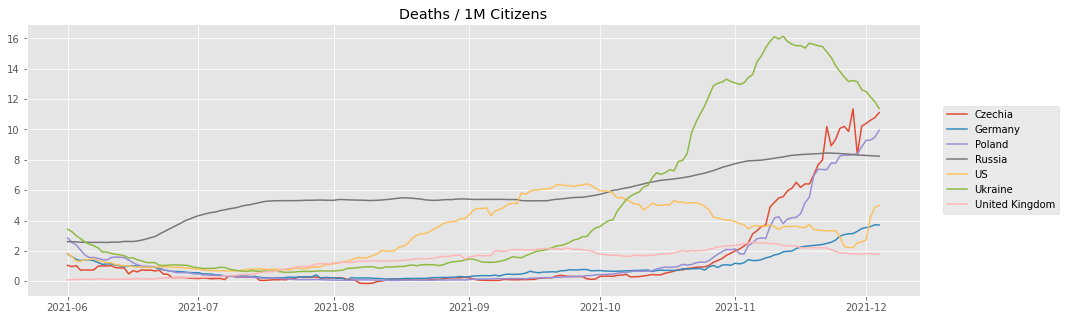

In [23]:
plot(cases_moving_average.loc[:, "deaths_per_mln"].unstack(level="country"), "Deaths / 1M Citizens")